# Import Resources

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import json
import tensorflow_hub as hub

# Load the Dataset

In [2]:
datasets, datainfo = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

In [3]:
train_set = datasets['train']
test_set = datasets['test']
validation_set = datasets['validation']

# Explore the Dataset

In [4]:
# Get the number of examples in each set from the dataset info

num_examples_train = datainfo.splits['train'].num_examples
num_examples_test = datainfo.splits['test'].num_examples
num_examples_validation = datainfo.splits['validation'].num_examples

print("The number of examples in train dataset: {}".format(num_examples_train))
print("The number of examples in test dataset: {}".format(num_examples_test))
print("The number of examples in validation dataset: {}".format(num_examples_validation))

The number of examples in train dataset: 1020
The number of examples in test dataset: 6149
The number of examples in validation dataset: 1020


In [5]:
# Get the number of classes in the dataset from the dataset info.

num_classes = datainfo.features['label'].num_classes

print("The number of classes in the dataset: {}".format(num_classes))

The number of classes in the dataset: 102


In [6]:
# Print the shape and corresponding label of 3 images in the training set.

for image, label in train_set.take(3):
    print('The images in the training set have:')
    print('\u2022 shape:', image.shape)
  
    print('\nThe label of the image:')
    print('\u2022 ', label)
    
    print("***************************************")

The images in the training set have:
• shape: (500, 667, 3)

The label of the image:
•  tf.Tensor(72, shape=(), dtype=int64)
***************************************
The images in the training set have:
• shape: (500, 666, 3)

The label of the image:
•  tf.Tensor(84, shape=(), dtype=int64)
***************************************
The images in the training set have:
• shape: (670, 500, 3)

The label of the image:
•  tf.Tensor(70, shape=(), dtype=int64)
***************************************


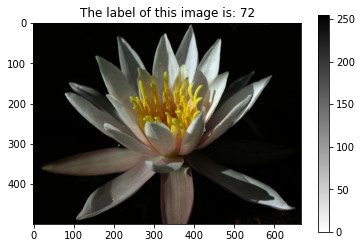

In [7]:
#  Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label.

for image, label in train_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.title('The label of this image is: {}'.format(label))
plt.show()

### Label Mapping

In [8]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

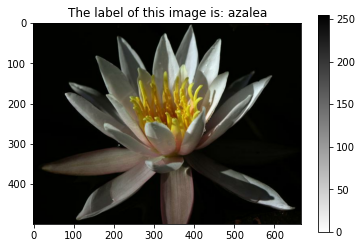

In [9]:
# Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name.

for image, label in train_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.title('The label of this image is: {}'.format(class_names[str(label)]))
plt.show()

### Create Pipeline

In [10]:
IMG_WIDTH=224
IMG_HEIGHT=224
batch_size = 64

In [11]:
def process_image(image, label):
    
    image = tf.cast(image, tf.float32)
    
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])

    image /= 255
    
    return image, label

In [12]:
train_set = train_set.map(process_image)
test_set = test_set.map(process_image)
validation_set = validation_set.map(process_image)

In [13]:
train_batches = train_set.shuffle(num_examples_train).batch(batch_size).prefetch(1)
test_batches = test_set.shuffle(num_examples_test).batch(batch_size).prefetch(1)
validation_batches = validation_set.shuffle(num_examples_validation).batch(batch_size).prefetch(1)

# Build and Train the Classifier

In [16]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

feature_extractor.trainable = False

In [18]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation = 'sigmoid'),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               130662    
_________________________________________________________________
dense_2 (Dense)              (None, 102)               10506     
Total params: 2,399,152
Trainable params: 141,168
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))